## Загрузка и подключение необходимых файлов

In [3]:
!wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-05.csv

--2020-04-29 06:28:47--  https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-05.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.36.126
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.36.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1858526595 (1.7G) [application/octet-stream]
Saving to: ‘yellow_tripdata_2016-05.csv.1’

  yellow_tripdata_2   1%[                    ]  27.61M  9.44MB/s               ^C


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
import datetime
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
taxi = pd.read_csv("yellow_tripdata_2016-05.csv", header = 0, skipinitialspace = True,
                             parse_dates = [1, 2],
                             date_parser = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [6]:
taxi.describe()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07
mean,1.529075e+00,1.662265e+00,6.110069e+00,-7.304978e+01,4.024234e+01,1.045014e+00,-7.311869e+01,4.028127e+01,1.349840e+00,1.334066e+01,3.291893e-01,4.972577e-01,1.831982e+00,3.422044e-01,2.996838e-01,1.664095e+01
std,4.991539e-01,1.304418e+00,5.155162e+03,8.212003e+00,4.523904e+00,6.203209e-01,7.902544e+00,4.353644e+00,4.942504e-01,1.188799e+01,4.585669e-01,4.473578e-02,2.665043e+00,1.760303e+00,1.300760e-02,1.450379e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,-1.650819e+02,-4.456935e+01,1.000000e+00,-1.295732e+02,0.000000e+00,1.000000e+00,-4.100000e+02,-3.900000e+01,-2.700000e+00,-8.000000e+01,-1.500000e+01,-3.000000e-01,-4.103000e+02
25%,1.000000e+00,1.000000e+00,1.000000e+00,-7.399179e+01,4.073611e+01,1.000000e+00,-7.399116e+01,4.073457e+01,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.760000e+00
50%,2.000000e+00,1.000000e+00,1.720000e+00,-7.398136e+01,4.075375e+01,1.000000e+00,-7.397922e+01,4.075439e+01,1.000000e+00,9.500000e+00,0.000000e+00,5.000000e-01,1.260000e+00,0.000000e+00,3.000000e-01,1.230000e+01
75%,2.000000e+00,2.000000e+00,3.270000e+00,-7.396588e+01,4.076862e+01,1.000000e+00,-7.396164e+01,4.077012e+01,2.000000e+00,1.500000e+01,5.000000e-01,5.000000e-01,2.450000e+00,0.000000e+00,3.000000e-01,1.836000e+01
max,2.000000e+00,9.000000e+00,1.200000e+07,1.184089e+02,5.366724e+01,9.900000e+01,0.000000e+00,7.012994e+01,5.000000e+00,8.007000e+03,7.900000e+01,4.030000e+01,7.500000e+02,1.120680e+03,3.100000e+00,8.007800e+03


In [0]:
labels = pd.read_csv("regions.csv", sep = ';')

## Очистка данных

In [0]:
taxi = taxi[(taxi['tpep_pickup_datetime'] != taxi['tpep_dropoff_datetime']) &
              (taxi.passenger_count > 0) & 
              (taxi.trip_distance > 0) & 
              (taxi['pickup_longitude'] <= -73.70001) & 
              (taxi['pickup_longitude'] >= -74.25559) & 
              (taxi['pickup_latitude'] <= 40.91553) & 
              (taxi['pickup_latitude'] >= 40.49612)]
taxi['tpep_pickup_datetime'] = taxi['tpep_pickup_datetime'].apply(lambda x: x.replace(minute = 0, second = 0))

## Считаем количество поездок

Используем binned_statistics_2d с биномиальным распределением

In [0]:
def get_trips(x, y, coords = [-74.25559, -73.70001, 40.49612, 40.91553]):
    west, east, south, north = coords
    counts = binned_statistic_2d(x, y, np.arange(len(x)), statistic = 'count', 
                                 range = [[west, east], [south, north]], 
                                 bins = [labels['west'].append(labels['east']).unique(), 
                                        labels['south'].append(labels['north']).unique()], 
                                 expand_binnumbers = True)
    return counts.statistic.ravel()

## Собираем поездки по датам

In [0]:
#считаем часы в каждом месяце

def get_hours(date):
    now_date = date.replace(day = 1, hour = 0, minute = 0, second = 0)
    target_month = now_date.month
    now_month = now_date.month
    res_list = []
    while now_month == target_month:
        res_list.append(now_date)
        now_date = now_date + datetime.timedelta(hours = 1)
        now_month = now_date.month
    return res_list

In [0]:
hours = get_hours(taxi['tpep_pickup_datetime'][0])
for hour in hours:
    values = np.zeros((labels.shape[0],))
    labels[hour] = values
    
#соберём статистику по поездкам
for hour in set(taxi['tpep_pickup_datetime']):
    h_chunk = taxi[taxi['tpep_pickup_datetime'] == hour]
    x = np.array(h_chunk['pickup_longitude'])
    y = np.array(h_chunk['pickup_latitude'])
    labels[hour] = np.array(labels[hour]) + get_trips(x, y)

In [16]:
col_ind = [0] + list(range(labels.shape[1]))[5:]
labels.iloc[0:2, col_ind]


,region,2016-05-01 00:00:00,2016-05-01 01:00:00,2016-05-01 02:00:00,2016-05-01 03:00:00,2016-05-01 04:00:00,2016-05-01 05:00:00,2016-05-01 06:00:00,2016-05-01 07:00:00,2016-05-01 08:00:00,2016-05-01 09:00:00,2016-05-01 10:00:00,2016-05-01 11:00:00,2016-05-01 12:00:00,2016-05-01 13:00:00,2016-05-01 14:00:00,2016-05-01 15:00:00,2016-05-01 16:00:00,2016-05-01 17:00:00,2016-05-01 18:00:00,2016-05-01 19:00:00,2016-05-01 20:00:00,2016-05-01 21:00:00,2016-05-01 22:00:00,2016-05-01 23:00:00,2016-05-02 00:00:00,2016-05-02 01:00:00,2016-05-02 02:00:00,2016-05-02 03:00:00,2016-05-02 04:00:00,2016-05-02 05:00:00,2016-05-02 06:00:00,2016-05-02 07:00:00,2016-05-02 08:00:00,2016-05-02 09:00:00,2016-05-02 10:00:00,2016-05-02 11:00:00,2016-05-02 12:00:00,2016-05-02 13:00:00,2016-05-02 14:00:00,...,2016-05-30 08:00:00,2016-05-30 09:00:00,2016-05-30 10:00:00,2016-05-30 11:00:00,2016-05-30 12:00:00,2016-05-30 13:00:00,2016-05-30 14:00:00,2016-05-30 15:00:00,2016-05-30 16:00:00,2016-05-30 17:00:00,2016-05-30 18:00:00,2016-05-30 19:00:00,2016-05-30 20:00:00,2016-05-30 21:00:00,2016-05-30 22:00:00,2016-05-30 23:00:00,2016-05-31 00:00:00,2016-05-31 01:00:00,2016-05-31 02:00:00,2016-05-31 03:00:00,2016-05-31 04:00:00,2016-05-31 05:00:00,2016-05-31 06:00:00,2016-05-31 07:00:00,2016-05-31 08:00:00,2016-05-31 09:00:00,2016-05-31 10:00:00,2016-05-31 11:00:00,2016-05-31 12:00:00,2016-05-31 13:00:00,2016-05-31 14:00:00,2016-05-31 15:00:00,2016-05-31 16:00:00,2016-05-31 17:00:00,2016-05-31 18:00:00,2016-05-31 19:00:00,2016-05-31 20:00:00,2016-05-31 21:00:00,2016-05-31 22:00:00,2016-05-31 23:00:00
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
labels.iloc[:, [0, 5, 6]]

,region,2016-05-01 00:00:00,2016-05-01 01:00:00
0,1,0.0,0.0
1,2,0.0,0.0
2,3,0.0,0.0
3,4,0.0,0.0
4,5,0.0,0.0
...,...,...,...
2495,2496,0.0,0.0
2496,2497,0.0,0.0
2497,2498,0.0,0.0
2498,2499,0.0,0.0


## Empire State Building

Text(0, 0.5, 'Trips')

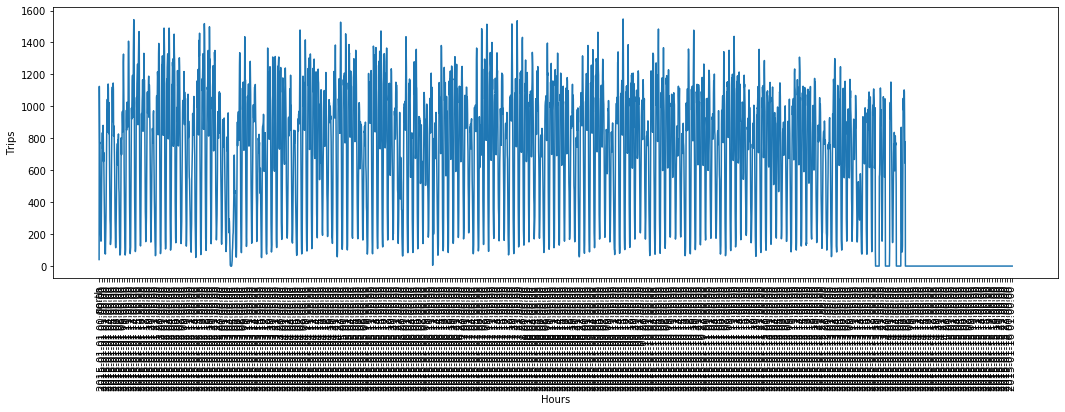

In [2]:
longitude = -73.985428
latitude = 40.748817
row = labels[(labels.west <= longitude) &  
             (labels.east >= longitude) & 
             (labels.south <= latitude) & 
             (labels.north >= latitude)]
trips = np.array(row.iloc[0, 5:])
hours = list(range(len(trips)))
plt.figure(figsize = (18, 5))
plt.plot(hours, trips)
plt.xlabel('Hours')
plt.xticks(hours[::12], list(labels.columns)[5:], rotation = 'vertical')
plt.ylabel('Trips')


## Сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки?

In [42]:
non_zeros = np.array(labels.iloc[:, 5:])
zeros = non_zeros.size - np.count_nonzero(non_zeros)
print('Всего в мае 2016 года всего пар час-ячейка:', non_zeros.size)
print("Из них нулевые:", zeros),
print("Доля в процентах %f %%" % round((zeros / non_zeros.size) * 100, 2))
                                                                        

Всего в мае 2016 года всего пар час-ячейка: 1860000
Из них нулевые: 1718238
Доля в процентах 92.380000 %


## О формате данных 
[Источник](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)